In [ ]:
import os
import random
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Load images
from PIL import Image
from skimage import img_as_float


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
DATA_DIR = '/content/drive/MyDrive/PROJEKAT_VI/rock_clasification/data/'

img_data = {}

for folder in os.listdir(DATA_DIR):
    img_path = DATA_DIR + folder + '/'
    img_data[folder] = [img_path + img for img in os.listdir(img_path)]

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Sample Images

In [ ]:
for i, folder in enumerate(img_data.keys()):
  print(folder)
  sample_size = 10
  images = [Image.open(x) for x in random.sample(img_data[folder], sample_size)]

  im_size = 128
  new_im = Image.new('RGB', (im_size*sample_size, im_size))

  x_offset = 0
  for im in images:
    im.thumbnail((im_size,im_size))
    new_im.paste(im, (x_offset,0))
    x_offset += im.size[0]

  display(new_im)

Output hidden; open in https://colab.research.google.com to view.

#Uklanjanje duplikata

Radi osiguravanja konzistentnosti i smanjenja redundantnosti unutar skupa podataka, provodi se detekcija i uklanjanje duplikata slika korištenjem metričke funkcije Srednje kvadratne greške (MSE). Svaka slika se učitava, normalizuje i upoređuje piksel po piksel. Ukoliko sličnost (obrnut MSE) između dvije slike pređe određeni prag, jedna od njih se označava za brisanje.

In [ ]:
def load_image(path, size=(256, 256)):
    img = Image.open(path)
    img = img.convert('RGB')
    img = img.resize(size)
    return img_as_float(img)



Funkcija mse računa srednju kvadratnu grešku između dvije slike tako što izračunava kvadratnu razliku svakog piksela i prosjek ukupne greške. Niža vrijednost označava veću sličnost.

In [ ]:
def mse(img1, img2):
    err = np.sum((img1 - img2) ** 2)
    err /= float(img1.shape[0] * img1.shape[1])
    return err



Definiše se prag osjetljivosti za detekciju duplikata. Za svaku sliku u mapi, porede se svi mogući parovi korištenjem MSE funkcije. U cilju optimizacije, poređenje se vrši samo između gornjih trouglastih parova (bez ponavljanja).

Indeksi originalnih i duplih slika se prate kako bi se izbjeglo višestruko brisanje. Ukoliko je MSE između dvije slike ispod praga, jedna se čuva kao referenca dok se druga označava za uklanjanje.

In [ ]:
dup_img_path = {}
threshold = 0.001  # osjetljivost – niže = strožije

for folder in img_data:
    img_list = img_data[folder]
    mse_mat = np.full((len(img_list), len(img_list)), np.inf)

    for i, img_path1 in enumerate(img_list[:-1]):
        img1 = load_image(img_path1)
        for j, img_path2 in enumerate(img_list[i+1:], start=i+1):
            img2 = load_image(img_path2)
            mse_mat[i, j] = mse(img1, img2)

    ori_img_idx = []
    dup_img_idx = []
    dup_img_path[folder] = []

    for i, j in zip(*np.where(mse_mat < threshold)):
        if i not in ori_img_idx and i not in dup_img_idx:
            ori_img_idx.append(i)
            dup_img_idx.append(j)
            dup_img_path[folder].append(img_list[j])
        elif i in dup_img_idx:
            dup_img_path[folder].append(img_list[j])


In [ ]:
import json

with open('/content/duplicate_img_path.json', 'w') as f:
    json.dump(dup_img_path, f, indent=2)


In [ ]:
for folder, paths in dup_img_path.items():
    for path in paths:
        if os.path.exists(path):
            os.remove(path)
            print(f"🗑️ Removed: {path}")




🗑️ Removed: /content/drive/MyDrive/PROJEKAT_VI/rock_clasification/data/Granite/2.jpg
🗑️ Removed: /content/drive/MyDrive/PROJEKAT_VI/rock_clasification/data/Granite/65.jpg
🗑️ Removed: /content/drive/MyDrive/PROJEKAT_VI/rock_clasification/data/Granite/75.JPEG
🗑️ Removed: /content/drive/MyDrive/PROJEKAT_VI/rock_clasification/data/Marble/s-l400.jpg
🗑️ Removed: /content/drive/MyDrive/PROJEKAT_VI/rock_clasification/data/Marble/marble2020(6).jpg
🗑️ Removed: /content/drive/MyDrive/PROJEKAT_VI/rock_clasification/data/Marble/marble-with-ruby.jpg
🗑️ Removed: /content/drive/MyDrive/PROJEKAT_VI/rock_clasification/data/Coal/193.jpg
🗑️ Removed: /content/drive/MyDrive/PROJEKAT_VI/rock_clasification/data/Coal/258.jpg
🗑️ Removed: /content/drive/MyDrive/PROJEKAT_VI/rock_clasification/data/Coal/68.jpg
🗑️ Removed: /content/drive/MyDrive/PROJEKAT_VI/rock_clasification/data/Coal/336.jpg
🗑️ Removed: /content/drive/MyDrive/PROJEKAT_VI/rock_clasification/data/Coal/348.jpg
🗑️ Removed: /content/drive/MyDrive/PROJ

#DATA SIZE

Distribucija vrsta stijena se nije značajno promijenila nakon uklanjanja duplikata.

Dataset je neuravnotežen, s osjetno manjim brojem slika za bazalt i granit.

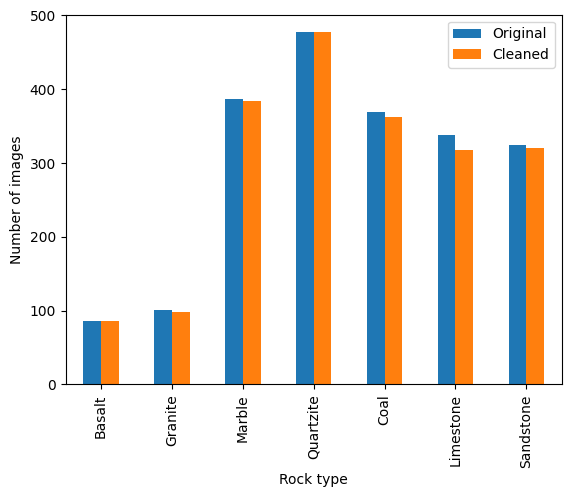

In [ ]:
num_img = [len(v) for k,v in img_data.items()]
num_clean_img = [len(v)-len(dup_img_path[k]) for k,v in img_data.items()]

df = pd.DataFrame(
    np.array([num_img, num_clean_img]).T,
    index=img_data.keys(),
    columns=['Original', 'Cleaned']
    )
ax = df.plot.bar()
ax.legend()
ax.set_ylabel('Number of images')
ax.set_xlabel('Rock type')
plt.show()